In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import os
import datetime as dt
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import cmocean
import json
import f90nml
from collections import OrderedDict
from scipy.stats.mstats import gmean
import xarray as xr
import netCDF4 as nc


fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display



%matplotlib inline



In [2]:
f=xr.open_dataset('/results2/SalishSea/nowcast-green.202111/06apr21/SalishSea_1d_20210406_20210406_chem_T.nc')

In [3]:
f

<xarray.Dataset> Size: 287MB
Dimensions:                     (time_counter: 1, deptht: 40, y: 898, x: 398)
Coordinates:
  * time_counter                (time_counter) datetime64[ns] 8B 2021-04-06T1...
  * deptht                      (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
  * y                           (y) int64 7kB 0 1 2 3 4 ... 893 894 895 896 897
  * x                           (x) int64 3kB 0 1 2 3 4 ... 393 394 395 396 397
Data variables:
    PAR                         (time_counter, deptht, y, x) float32 57MB ...
    turbidity                   (time_counter, deptht, y, x) float32 57MB ...
    dissolved_inorganic_carbon  (time_counter, deptht, y, x) float32 57MB ...
    total_alkalinity            (time_counter, deptht, y, x) float32 57MB ...
    dissolved_oxygen            (time_counter, deptht, y, x) float32 57MB ...
    CO2_flux                    (time_counter, y, x) float32 1MB ...
Attributes:
    name:         SalishSeaCast_1d_chem_T_20210406_20210406
    description:  Day-averaged chemistry variables resampled from v202111 Sal...
    history:      2023-01-27 19:06 -08:00: Generated by reshapr.api.v1.extrac...
    Conventions:  CF-1.6

In [4]:
data=pd.read_csv('/data/rbeutel/obs/PNW_obs_compiled.csv')

In [5]:
data.keys()

Index(['Unnamed: 0', 'time', 'longitude (degrees_east)',
       'latitude (degrees_north)', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)',
       'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'Co (nmol kg-1)', 'source',
       'Nstar (umol kg-1)', 'spice'],
      dtype='object')

In [6]:
data['DIC (uM)']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
           ..
3464566   NaN
3464567   NaN
3464568   NaN
3464569   NaN
3464570   NaN
Name: DIC (uM), Length: 3464571, dtype: float64

In [7]:
data['time']=pd.to_datetime(data['time']) 

In [8]:
data['time']

0         1930-11-07 00:00:00+00:00
1         1930-11-07 00:00:00+00:00
2         1930-11-07 00:00:00+00:00
3         1930-11-07 00:00:00+00:00
4         1930-11-07 00:00:00+00:00
                     ...           
3464566   2024-07-10 00:00:00+00:00
3464567   2024-07-10 00:00:00+00:00
3464568   2024-07-10 00:00:00+00:00
3464569   2024-07-10 00:00:00+00:00
3464570   2024-07-10 00:00:00+00:00
Name: time, Length: 3464571, dtype: datetime64[ns, UTC]

In [9]:
data['Year']=[ii.year for ii in data['time']]
data['Month']=[ii.month for ii in data['time']]
#data['YD']=et.datetimeToYD(data['time'])

In [10]:
data['Year']

0          1930
1          1930
2          1930
3          1930
4          1930
           ... 
3464566    2024
3464567    2024
3464568    2024
3464569    2024
3464570    2024
Name: Year, Length: 3464571, dtype: int64

In [11]:
data['YMO']=pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))

In [12]:
data.rename(columns={'longitude (degrees_east)':'Lon','latitude (degrees_north)':'Lat'},inplace=True) 

In [13]:
data=data[~(data['Lon'] < -124) & (data['Lat'] < 50.0)] #

In [14]:
data=data[(data['Year'] >= 2007) & (data['Year'] <= 2024)]

In [15]:
specific_rows = data[data['DIC (uM)'] > 2000 ]
print(specific_rows)

         Unnamed: 0                      time     Lon    Lat  depth (m)  \
1816904     1816904 2007-05-14 08:00:00+00:00  -81.66  25.35        2.0   
1823288     1823288 2007-05-26 01:00:00+00:00  -69.54  42.60        7.0   
1823733     1823733 2007-05-27 20:00:00+00:00 -123.98  38.14       10.0   
1823734     1823734 2007-05-27 20:00:00+00:00 -123.98  38.14       16.0   
1823735     1823735 2007-05-27 20:00:00+00:00 -123.98  38.14       22.0   
...             ...                       ...     ...    ...        ...   
2995281     2995281 2018-11-21 19:00:00+00:00  -60.22  45.24        7.0   
2995282     2995282 2018-11-21 21:00:00+00:00  -60.68  45.11        7.0   
2995283     2995283 2018-11-21 23:00:00+00:00  -61.17  44.95        7.0   
2995653     2995653 2018-11-22 01:00:00+00:00  -61.44  44.87        7.0   
2995654     2995654 2018-11-22 04:00:00+00:00  -61.69  44.82        7.0   

         pressure (dbar)  temperature (degC)  salinity (g kg-1)  \
1816904              1.5        

In [16]:
data

,Unnamed: 0,time,Lon,Lat,depth (m),pressure (dbar),temperature (degC),salinity (g kg-1),DO (umol kg-1),NO3 (uM),...,Mn (nmol kg-1),Ni (nmol kg-1),Zn (nmol kg-1),Co (nmol kg-1),source,Nstar (umol kg-1),spice,Year,Month,YMO
1789724,1789724,2007-01-04 16:00:00+00:00,-122.64,47.55,1.0,1.00,8.606199,28.508941,244.435192,29.709999,...,NaN,NaN,NaN,NaN,department of ecology,-9.184175,-3.789279,2007,1,2007-01-01
1789725,1789725,2007-01-04 16:00:00+00:00,-122.64,47.55,2.0,2.00,8.866898,28.684785,241.213372,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-3.623211,2007,1,2007-01-01
1789726,1789726,2007-01-04 16:00:00+00:00,-122.64,47.55,3.0,3.00,8.993597,28.832727,237.039771,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-3.497011,2007,1,2007-01-01
1789727,1789727,2007-01-04 16:00:00+00:00,-122.64,47.55,4.0,4.00,9.041230,28.901657,234.149288,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-3.439876,2007,1,2007-01-01
1789728,1789728,2007-01-04 16:00:00+00:00,-122.64,47.55,5.0,5.00,9.073196,28.951931,231.699952,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-3.398608,2007,1,2007-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459964,3459964,2023-12-11 20:00:00+00:00,-123.94,46.46,10.0,10.00,8.921193,19.145964,307.570665,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-10.494774,2023,12,2023-12-01
3459965,3459965,2023-12-11 20:00:00+00:00,-123.94,46.46,11.0,11.00,8.917892,19.414013,306.858271,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-10.302047,2023,12,2023-12-01
3459966,3459966,2023-12-11 20:00:00+00:00,-123.94,46.46,12.0,12.00,8.917191,19.460211,307.028682,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-10.268847,2023,12,2023-12-01
3459967,3459967,2023-12-11 20:00:00+00:00,-123.94,46.46,13.0,13.00,8.917091,19.470036,307.458079,NaN,...,NaN,NaN,NaN,NaN,department of ecology,NaN,-10.261781,2023,12,2023-12-01


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


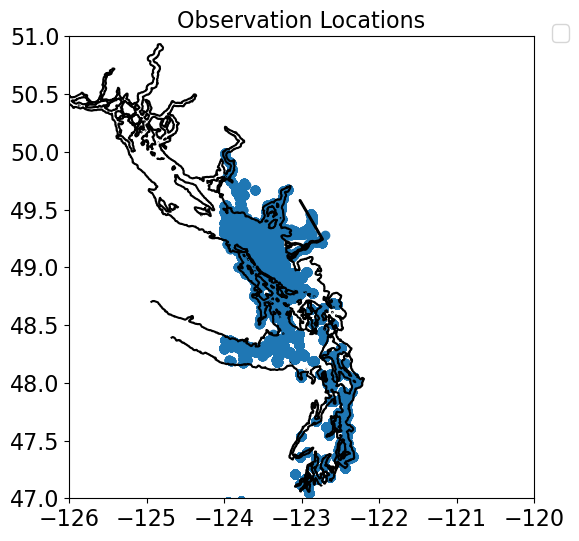

In [17]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('teal','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue','lightblue')
#datreg=dict()
#for ind, iregion in enumerate(data.region_name.unique()):
#    datreg[iregion] = data.loc[data.region_name==iregion]
ax.scatter(data['Lon'], data['Lat'],marker='o') #color = colors[ind]
ax.set_ylim(47,51)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-126, -120);
ax.set_title('Observation Locations');
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [18]:
data.keys()

Index(['Unnamed: 0', 'time', 'Lon', 'Lat', 'depth (m)', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)',
       'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'Co (nmol kg-1)', 'source',
       'Nstar (umol kg-1)', 'spice', 'Year', 'Month', 'YMO'],
      dtype='object')

In [19]:
data.time

1789724   2007-01-04 16:00:00+00:00
1789725   2007-01-04 16:00:00+00:00
1789726   2007-01-04 16:00:00+00:00
1789727   2007-01-04 16:00:00+00:00
1789728   2007-01-04 16:00:00+00:00
                     ...           
3459964   2023-12-11 20:00:00+00:00
3459965   2023-12-11 20:00:00+00:00
3459966   2023-12-11 20:00:00+00:00
3459967   2023-12-11 20:00:00+00:00
3459968   2023-12-11 20:00:00+00:00
Name: time, Length: 566322, dtype: datetime64[ns, UTC]

In [20]:
data.rename(columns={'time':'dtUTC','depth (m)':'Z'},inplace=True)

In [21]:
data.keys()

Index(['Unnamed: 0', 'dtUTC', 'Lon', 'Lat', 'Z', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)',
       'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'Co (nmol kg-1)', 'source',
       'Nstar (umol kg-1)', 'spice', 'Year', 'Month', 'YMO'],
      dtype='object')

In [22]:
import netCDF4 as nc

In [23]:
f.keys()

KeysView(<xarray.Dataset> Size: 287MB
Dimensions:                     (time_counter: 1, deptht: 40, y: 898, x: 398)
Coordinates:
  * time_counter                (time_counter) datetime64[ns] 8B 2021-04-06T1...
  * deptht                      (deptht) float32 160B 0.5 1.5 ... 414.5 441.5
  * y                           (y) int64 7kB 0 1 2 3 4 ... 893 894 895 896 897
  * x                           (x) int64 3kB 0 1 2 3 4 ... 393 394 395 396 397
Data variables:
    PAR                         (time_counter, deptht, y, x) float32 57MB ...
    turbidity                   (time_counter, deptht, y, x) float32 57MB ...
    dissolved_inorganic_carbon  (time_counter, deptht, y, x) float32 57MB ...
    total_alkalinity            (time_counter, deptht, y, x) float32 57MB ...
    dissolved_oxygen            (time_counter, deptht, y, x) float32 57MB ...
    CO2_flux                    (time_counter, y, x) float32 1MB ...
Attributes:
    name:         SalishSeaCast_1d_chem_T_20210406_20210406
    d

In [29]:
fdict={'chem_T':1,'biol_T':1}
start_date = dt.datetime(2015,1,1)#previous results used (2012,1,1)
end_date = dt.datetime(2018,12,31) #previous results used (2016,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'dissolved_inorganic_carbon':'chem_T','total_alkalinity':'chem_T','dissolved_oxygen':'chem_T',\
        'nitrate':'biol_T','ammonium':'biol_T','silicon':'biol_T','diatoms':'biol_T','flagellates':'biol_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'chem_T':1,'biol_T':1}

In [30]:
data.dtUTC

1789724   2007-01-04 16:00:00
1789725   2007-01-04 16:00:00
1789726   2007-01-04 16:00:00
1789727   2007-01-04 16:00:00
1789728   2007-01-04 16:00:00
                  ...        
3459964   2023-12-11 20:00:00
3459965   2023-12-11 20:00:00
3459966   2023-12-11 20:00:00
3459967   2023-12-11 20:00:00
3459968   2023-12-11 20:00:00
Name: dtUTC, Length: 566322, dtype: datetime64[ns]

In [31]:
data['dtUTC']=pd.to_datetime(data.dtUTC).dt.tz_localize(None)

In [32]:
PATH= '/results2/SalishSea/nowcast-green.202111/'

In [33]:
data=et.matchData(data,filemap,fdict,start_date,end_date,'nowcast',PATH,1,quiet=False,method='bin');

(Lat,Lon)= 18.83 -93.07  not matched to domain
(Lat,Lon)= 19.17 -93.3  not matched to domain
(Lat,Lon)= 19.61 -93.51  not matched to domain
(Lat,Lon)= 20.02 -93.78  not matched to domain
(Lat,Lon)= 20.6 -94.29  not matched to domain
(Lat,Lon)= 20.73 -94.73  not matched to domain
(Lat,Lon)= 21.17 -90.76  not matched to domain
(Lat,Lon)= 21.45 -91.57  not matched to domain
(Lat,Lon)= 21.55 -86.75  not matched to domain
(Lat,Lon)= 21.59 -86.5  not matched to domain
(Lat,Lon)= 21.63 -86.25  not matched to domain
(Lat,Lon)= 21.67 -86.01  not matched to domain
(Lat,Lon)= 21.72 -85.72  not matched to domain
(Lat,Lon)= 21.74 -92.31  not matched to domain
(Lat,Lon)= 21.76 -85.47  not matched to domain
(Lat,Lon)= 21.8 -85.21  not matched to domain
(Lat,Lon)= 21.83 -84.98  not matched to domain
(Lat,Lon)= 21.93 -88.0  not matched to domain
(Lat,Lon)= 22.0 -92.9  not matched to domain
(Lat,Lon)= 22.27 -97.73  not matched to domain
(Lat,Lon)= 22.27 -97.65  not matched to domain
(Lat,Lon)= 22.27 -97

In [34]:
data.keys()

Index(['Unnamed: 0', 'dtUTC', 'Lon', 'Lat', 'Z', 'pressure (dbar)',
       'temperature (degC)', 'salinity (g kg-1)', 'DO (umol kg-1)', 'NO3 (uM)',
       'NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'Chl (mg m-3)',
       'TA (uM)', 'DIC (uM)', 'Carbonate', 'Aragonite', 'Calcite',
       'Cd (nmol kg-1)', 'Cu (nmol kg-1)', 'Fe (nmol kg-1)', 'Mn (nmol kg-1)',
       'Ni (nmol kg-1)', 'Zn (nmol kg-1)', 'Co (nmol kg-1)', 'source',
       'Nstar (umol kg-1)', 'spice', 'Year', 'Month', 'YMO', 'j', 'i',
       'mod_dissolved_inorganic_carbon', 'mod_total_alkalinity',
       'mod_dissolved_oxygen', 'mod_nitrate', 'mod_ammonium', 'mod_silicon',
       'mod_diatoms', 'mod_flagellates', 'k'],
      dtype='object')

In [35]:
len(data['DIC (uM)'])

144312

In [36]:
data['DIC (uM)'].max()

2336.1470329163385

In [38]:
#data.to_csv('PugetSound_CarbonateChemModelvsObsMatches_2007to2024_Eval202111.csv') #pandas to csv and split the notebook with the remainder of the notebook; name effectively because you will reuse this